Лабораторная работа №2. Методы стеганоанализа
Коршиков В.И., группа 6233-010402D

Сергунин С.К., группа 6233-010402D

Создание датасета
Реализовать процедуру расчёта векторов признаков, используемых для стегоанализа.

Выполнить имитацию работы стегосистемы для первых 𝐾2⁄ изображений: встроить в каждое изображение в качестве стеганографической информации отдельную реализацию равномерного белого шума (число бит определяется текущим значением 𝑞). Вторую половину изображений не менять.

входными данными, необходимыми для выполнения лабораторной работы, являются 𝐾 полутоновых изображений одного размера.

стеганографическая система: м+-1 встраивание (запись по псевдослучайным координатам, 1-я битовая плоскость)

метод стеганоанализа: Метод длин серий (в качестве признаков - количество серий длин от 5 до 12)

Замена 
create_location = keygen

location = key

a = replaced_pixel



In [2]:
# Подключим гугл диск
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os, sys
import pandas as pd

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import random
from random import random, randrange, randint

from operator import itemgetter



In [4]:
# процент пикселов, в которых будут изменения (размер сообщения)

def message_size_identifier(image, percent):
    message_size = round(image.size/100)*percent
    return message_size

In [5]:
# Теперь, когда мы знаем длину сообщения, необходимо задать, в каких местах изображения разместить пиксели, которые входят в сообщение



def keygen(image, message_size):
    image_size = image.size
    key = np.random.permutation(np.arange(0, image_size))[:message_size]
    return key

# Переменная key  включает в себя набор местоположений пикселей, содержащих сообщение, то есть является ключом шифрования и дешифрования

In [6]:
# Зададим функцию для генерации белого шума, чтобы имитировать передачу сообщения
def encoder (image, key):
  # Конвертируем изображение в одномерный массив
    img_flatten = image.flatten()

     # Находим пиксели, которые необходимо заменить
    for k in key:
        replaced_pixel = img_flatten[k]
        
        # Пиксель может принимать два значения: 0 (чёрный) и 1 (белый). Зарандомим значение для каждого пиксела
        noise = randint(0, 1)
        
        # Теперь необходимо представить числа в двоичном виде. Длина этого числа составляет 8 символов (так как у нас 8 бит)
        replaced_pixel = np.binary_repr(replaced_pixel, width=8)
        noise = np.binary_repr(noise, width=8)
        
        # Теперь необходимо получить значение той цифры в бинарном изображении, которую мы будем заменять. Тут заменяется 8-ай цифра 
        xor_replaced_pixel_noise = int(replaced_pixel[7]) ^ int(noise[7])
        
        # Получаем новое двоичное число, отняв последнюю цифру и прибавив вместо неё xor_replaced_pixel_noise
        new = replaced_pixel[:-1] + str(xor_replaced_pixel_noise)
        
        # записываем в формате uint8
        new = (int(new, 2))
        
        # Добавляем получившееся значение в одномерный массив
        img_flatten[k] = new
    
    # Конвертируем одномерный массив, наполненный новыми значениями, в изображение 
    img_new = np.reshape(img_flatten, image.shape)    
    return img_new    

In [7]:
# Как вектор признаков используется набор длин серий одинаковых младших бит (0 или 1), длина которых будет составять от 1 до 12 символов
# В тех изображениях, где зашифрованное сообщение не содержится, ожидается, что серий длиной от 5 и выше окажется больше

# Серия - последовательность младших бит, состоящая из одинаковых элементов (0 или 1)
# У пустых контейнеров количество таких серий ожидается больше начиная с длины 5-6

def img_series(image):
  # Конвертируем изображение в одномерный массив
    flatten_image = image.flatten()

    # все переводим в двоичное число и записываем в одну строку
    giant_binary_number = ''
    for i in flatten_image:
        i = np.binary_repr(i, width=8)
        giant_binary_number = giant_binary_number + i[7]

    # зададим переменную, которая будет считать количество одинаковых подряд идущих нулей или единиц, счёт начнём с одного
    combo = 1
    
    # создадим список, который будет содержать в себе последовательность всех серий внутри giant_binary_number
    combo_list = []
    
    # так как мы сравниваем текущий номер с последующим, уменьшаем длину на 1
    for digit_number in range(len(giant_binary_number) - 1):
        # Проверяем, равна ли выбранная цифра последующей, если равна, увеличиваем счётчик серии(combo)
        if giant_binary_number[digit_number] == giant_binary_number[digit_number + 1]:
            combo += 1
        else:
          # Если серия прерывается, записываем значение счётчика серии в список и считаем дальше
            combo_list.append(combo)
            combo = 1
    # записываем последнее значение длины серии        
    combo_list.append(combo)
    
  # Создадим список возможных длин серий
    list_of_possible_combo_length = list(range(1, 13))

  # Найдём количество значений для каждой возможной длины
    each_length_quantity = []
    quantity = 0

    for length in list_of_possible_combo_length:
      for combo in combo_list:
        if length == combo:
          quantity +=1
      each_length_quantity.append(quantity)
      quantity = 0

    # Теперь добавим получившиеся значения в словарь
    
    
    dict_combo = dict(zip(list_of_possible_combo_length, each_length_quantity))


  
    return (dict_combo)

In [8]:
# продемонстрируем для одного изображения

# считаем изображение с Гугл диска
image_example = cv2.imread('/content/drive/MyDrive/Science_article/photo.jpg', 0)
percent = 50


message_size = message_size_identifier(image_example, percent)
print(message_size)
key = keygen(image_example, message_size)
print(key)
image_example_with_message = encoder(image_example, key)
difference_between_images = image_example_with_message - image_example


print(img_series(image_example))
print(img_series(image_example_with_message))

960000
[1425589 1421299 1752883 ... 1189613 1659204 1323435]
{1: 436991, 2: 245125, 3: 103268, 4: 51782, 5: 24215, 6: 12720, 7: 5622, 8: 6667, 9: 5094, 10: 3585, 11: 2152, 12: 1175}
{1: 469770, 2: 237876, 3: 116209, 4: 58600, 5: 30074, 6: 15469, 7: 8078, 8: 4466, 9: 2439, 10: 1365, 11: 732, 12: 400}


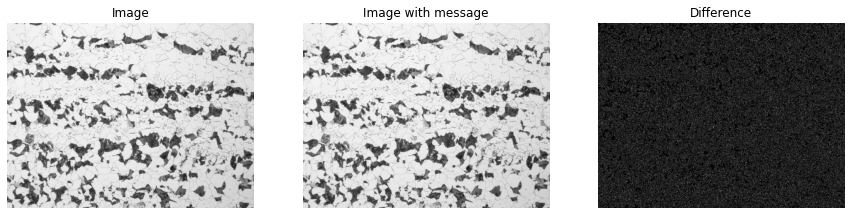

In [9]:
plt.figure(figsize=(15,15))

plt.subplot(1, 3, 1)
plt.axis('off')
plt.title('Image')
plt.imshow(image_example, cmap='gray')

plt.subplot(1, 3, 2)
plt.axis('off')
plt.title('Image with message')
plt.imshow(image_example_with_message, cmap='gray')

plt.subplot(1, 3, 3)
plt.axis('off')
plt.title('Difference')
plt.imshow(difference_between_images, cmap='gray')

plt.show()

In [10]:
def create_dataset (percent, dir_name):
    # создаем пустой датасет
    df_title = {'Image Name': [], 'series length 1': [], 'series length 1': [],
                'series length 2': [], 'series length 3': [],'series length 4': [],
                'series length 5': [], 'series length 6': [], 'series length 7': [],
                'series length 8': [], 'series length 9': [], 'series length 10': [],
                'series length 11': [],'series length 12': [], 'with message': []}
    df = pd.DataFrame(df_title)

    # имя новой папки
    new_dir_name = 'drive/MyDrive' + '/' + str(percent) + '/'
    if os.path.exists(new_dir_name) == False:
        os.mkdir(new_dir_name)

    
    # в первые 50% зашифровываем сообщение, считаем длины серий. Метка "with message" = 1
    pictures = os.listdir(dir_name)
    len_1 = len(pictures) // 2
    
    list_df1 = []

    for k in range(len_1):
        im = cv2.imread(f'{dir_name}{pictures[k]}', 0)
        if type(im) == np.ndarray:
            # процент занимаемый сообщением
            pixel_change = message_size_identifier(im, percent)
            # местоположение сообщения на изображении
            location = keygen(im, pixel_change)
            # кодируем сообщение
            img_with_massage = encoder(im, location)
        
            list_series1 = img_series(img_with_massage)
            list_df1.append({'Image Name': pictures[k], 'series length 1': list_series1[1],
                        'series length 1': list_series1[1],'series length 2': list_series1[2],
                        'series length 3': list_series1[3],'series length 4': list_series1[4],
                        'series length 5': list_series1[5],'series length 6': list_series1[6],
                        'series length 7': list_series1[7],'series length 8': list_series1[8],
                        'series length 9': list_series1[9],'series length 10': list_series1[10],
                        'series length 11': list_series1[11],'series length 12': list_series1[12],
                        'with message': 1})

            # сохраняем измененное в новую папку
            #cv2.imwrite(f'{new_dir_name}{pictures[k]}', img_with_massage)
        # для оставшихся 50% считаем длины серий. Метка "with message" = 0
    list_df2 = []
    for k in range(len_1, len(pictures)):
        im = cv2.imread(f'{dir_name}{pictures[k]}', 0)
        if type(im) == np.ndarray:
            list_series2 = img_series(im)
            list_df2.append({'Image Name': pictures[k], 'series length 1': list_series2[1],
                        'series length 1': list_series2[1],'series length 2': list_series2[2],
                        'series length 3': list_series2[3],'series length 4': list_series2[4],
                        'series length 5': list_series2[5],'series length 6': list_series2[6],
                        'series length 7': list_series2[7],'series length 8': list_series2[8],
                        'series length 9': list_series2[9],'series length 10': list_series2[10],
                        'series length 11': list_series2[11],'series length 12': list_series2[12],
                        'with message': 0})
            
            # сохраняем измененное в новую папку
            #cv2.imwrite(f'{new_dir_name}{pictures[k]}', im)
    
    df = df.append(list_df1)
    df = df.append(list_df2)
    return df

In [11]:
for number in [20, 30, 40, 50, 60, 70, 80, 90, 100]:
    df2 = create_dataset (number, '/content/drive/MyDrive/BOW2/')
    df2.to_csv('/content/drive/MyDrive/LSB_'+str(number)+'.csv', index=False)